In [31]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import os
from tqdm import tqdm_notebook
import matplotlib.style as mplstyle

In [2]:
#check current working directory
retval = os.getcwd()
print ("Current working directory %s" %retval)

# change directory
os.chdir(r'C:\Users\megas\Documents\Cal\NEFall2022\NE204')

Current working directory C:\Users\megas\Documents\GitHub_NE-204\Lab-1


In [3]:
#check current working directory
retval = os.getcwd()
print ("Current working directory %s" %retval)

Current working directory C:\Users\megas\Documents\Cal\NEFall2022\NE204


In [4]:
#Input the data file and find the keys
f = h5py.File(r"C:\Users\megas\Documents\Cal\NEFall2022\Detectors204\lab1\923Data\Cs137-1min.h5", 'r')

#print the keys for the file path
print(f.keys())
print(f['raw_data'])

<KeysViewHDF5 ['event_data', 'raw_data']>
<HDF5 dataset "raw_data": shape (3162, 62500), type "<u2">


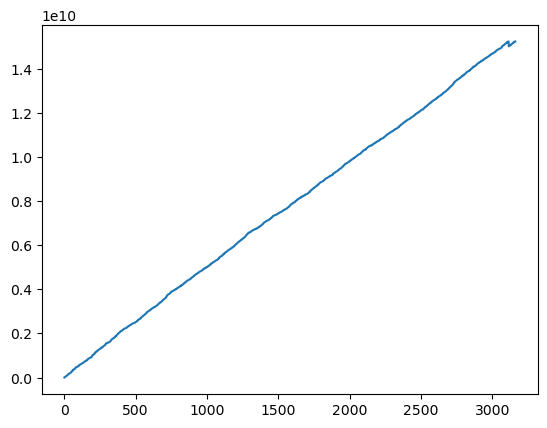

In [5]:
#The second of data is repeated - remove from consideration
plt.plot(f['event_data']['timestamp'])

In [6]:
pulses = np.array(f['raw_data'])
pulses = pulses[:-1]

In [7]:
print(type(pulses), pulses.shape)

<class 'numpy.ndarray'> (3161, 62500)


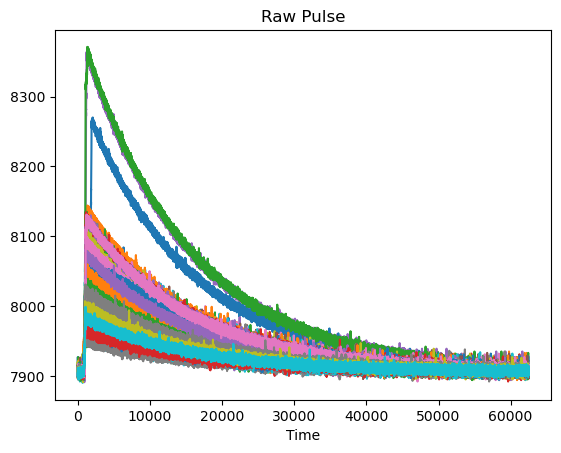

In [8]:
#Plot the raw data
plt.figure()

for i in range(0, 100):
    plt.plot(pulses[i])
    plt.xlabel('Time')
    plt.title('Raw Pulse')

In [9]:
#remove saturated signals
sat = np.amax(np.amax(pulses))
print("The saturation value is", sat)

nonsat_pulses = []
for i in range(len(pulses)):
    max_y = np.amax(pulses[i])
    if (max_y != sat):
        nonsat_pulses.append(pulses[i])

nonsat_pulses = np.array(nonsat_pulses)
print(nonsat_pulses.shape)   
print(pulses.shape)

The saturation value is 16383
(3134, 62500)
(3161, 62500)


<class 'numpy.ndarray'>
(3134, 62500)


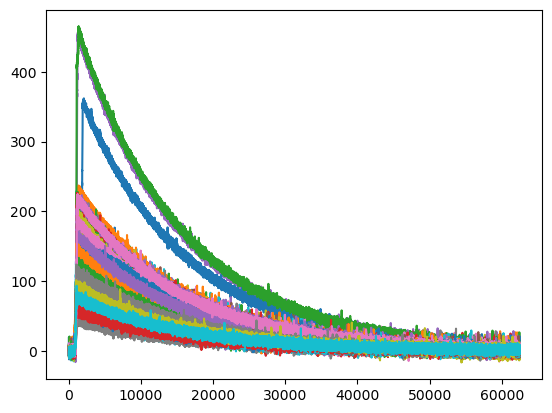

In [10]:
#Background subtraction for the raw data
n = len(nonsat_pulses)
print(type(nonsat_pulses))
pulses_sub = []
for i in range(n):
    bkg = np.mean(nonsat_pulses[i][0:500])
    pulses_sub.append(nonsat_pulses[i] - bkg)
    
pulses_sub = np.array(pulses_sub)
print(pulses_sub.shape)
for i in range(100):
    plt.plot(pulses_sub[i])

The average noise height is: 9.1475
The minimum noise height is: 6.5 The maximum noise height is: 21.5


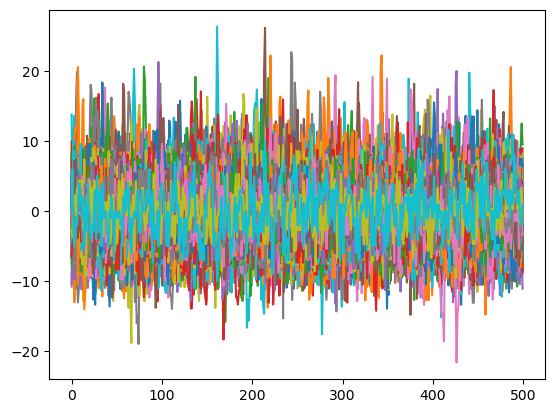

In [11]:
#Plotting the pre-trigger area for a look at the background
#getting the average noise height
noiseh = []
noisemin_ar = []
noisemax_ar = []
plt.figure()
for i in range(1000):
    plt.plot(pulses_sub[i][0:500])
    noisemin = np.amin(pulses_sub[i][0:500])
    noisemin_ar.append(noisemin)
    noisemax = np.amax(pulses_sub[i][0:500])
    noisemax_ar.append(noisemax)
    half = (noisemax-noisemin)/2
    noiseh.append(half)
    
avg_noiseh = np.mean(noiseh)
print("The average noise height is:", avg_noiseh)
print("The minimum noise height is:", np.amin(noiseh), "The maximum noise height is:", np.amax(noiseh))

<class 'numpy.ndarray'> (3134, 62500)


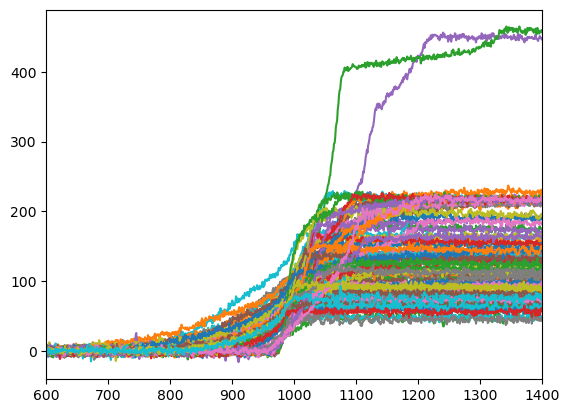

In [12]:
#Plotting the rise of a bunch of data to see possible pileup
for i in range (100):
    plt.plot(pulses_sub[i]) 
    plt.xlim(600,1400) #we expect the rise to be around the pre-trigger value 1000t
    
print(type(pulses_sub), pulses_sub.shape)

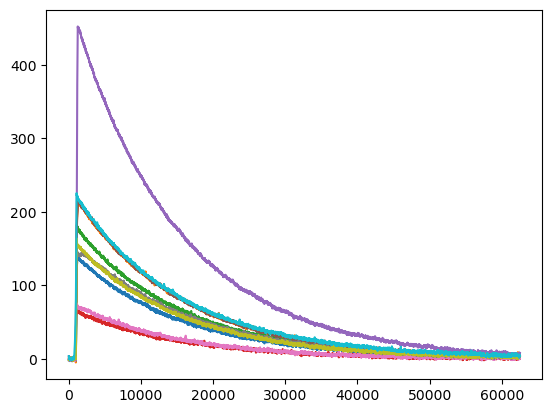

In [13]:
#filtering the signals
fs = savgol_filter(pulses_sub, 51, 2)
for i in range(10):
    plt.plot(fs[i])

In [14]:
#Let's get the upper and lower bounds of the rise time, and find k, the rise time
def get_k(signal):
    end_index = np.argmax(signal)
    diff_list = []
    N = 0
    diff_array = np.array([signal[end_index] - signal[end_index - n] for n in range(end_index)])
    med = np.median(diff_array)
    for n in range(len(diff_array)):
        if diff_array[n]>0.998*med:
            N = n
            break
    return N

k = []
for i in range(len(fs)):
    k.append(get_k(fs[i]))

kavg = np.mean(k)
print(kavg)

350.74122527121887


In [15]:
#defining an exponential function
def exp_func(x, a, b, c):
    #returns a times e^(-b times a) + c
    return a * np.exp(-b * x) + c

(2000,)


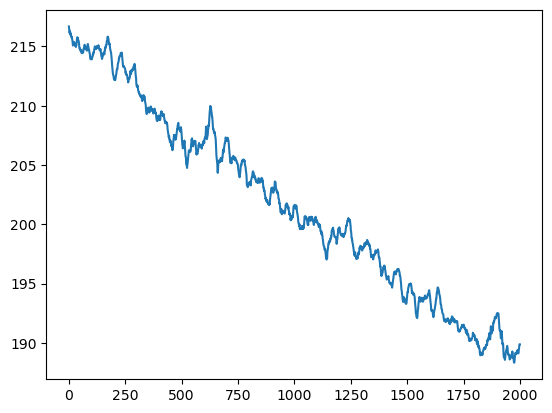

In [16]:
#find the index of the max value for each fitted signal
imax = []
for i in range(len(fs)):
    imax.append(np.argmax(fs[i]))
    
plt.plot(fs[5][imax[5]:2000+imax[5]])
print(fs[5][imax[5]:2000+imax[5]].shape)

In [32]:
#fit an exponential curve to the decay of each signal to find tau
tau = []
for i in tqdm(range(100)):
    #setting the ranges for exp fitting and x axis parameters
    endfit = 20000
    s = imax[i] #index of max for pulse i
    x = np.arange(0, endfit) #array of values from max index upward for some number of indices, len(x)=endfit
    
    #using exp_func over the values in x
    #fits an exp to the ith pulse from index of max to endfit+index of max
    try:
        popt, pcov = curve_fit(exp_func, x, fs[i][s:endfit+s])
        tau.append(1/popt[1])
    except:
        tau.append(0)

tau = list(filter(lambda a: a != 0, tau))
tau = np.array(tau)
tau_avg = np.mean(tau)
print(tau_avg)
    
#plot fitted exponential against bkg sub raw data
#plt.plot(range(s,s+len(exp_func(x, *popt))),exp_func(x, *popt))
#plt.scatter(np.arange(0,len(fs[i])),fs[i], s=1, color='orange')

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


15689.012095345792
